In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.lines import Line2D
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
import seaborn as sns
from joblib import Parallel, delayed
import math
from scipy.stats import multivariate_normal

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [3]:
# generate data 
def online_sample_from_task_sequence(t, N=20, d=2):
    if (t // N) % 2 == 0:
        mu = np.array([1, 1])
    else:
        mu = np.array([-1, -1])    
    Y = np.random.binomial(1, 0.5)
    X = np.random.multivariate_normal((-1)**(Y+1)*mu, np.eye(d))
    return X, 2*Y-1

def batch_sample_from_task_sequence(n, t, N=20, d=2, seed=1996):
    if (t // N) % 2 == 0:
        mu = np.array([1, 1])
    else:
        mu = np.array([-1, -1])    
    X = np.concatenate((np.random.multivariate_normal((-1)*mu, np.eye(d), size=n // 2),
                        np.random.multivariate_normal(mu, np.eye(d), size=n // 2)))
    Y = np.concatenate((-np.ones(n // 2), np.ones(n // 2)))
    return X, Y

In [4]:
# transformer archiecture
class LinearLayer(nn.Module):
    def __init__(self, d_model, hidden_dim, p):
        super().__init__()
        self.linear1 = nn.Linear(d_model,    hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

class AttentionLayer(nn.Module):
    def __init__(self, d_model, num_heads, conv_hidden_dim, p=0.1, causal=False):
        super().__init__()
        self.causal = causal

        self.mha = nn.MultiheadAttention(d_model, num_heads, p)
        self.cnn = LinearLayer(d_model, conv_hidden_dim, p)

        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
    
    def forward(self, x):
        if self.causal:
            mask = torch.triu(torch.full((len(x), len(x)), float('-inf'), device=device), diagonal=1)
        else:
            mask = None
        attn_output, _ = self.mha(x, x, x, attn_mask=mask)
        out1 = self.layernorm1(x + attn_output)
        cnn_output = self.cnn(out1)
        out2 = self.layernorm2(out1 + cnn_output)
        return out2
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout= 0.0, max_len= 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(1, max_len, d_model)
        theta = np.array([
            [p / np.power(10000, 2 * (j // 2) / d_model) for j in range(d_model)]
            for p in range(max_len)
        ])
        pe[:, :, 0::2] = torch.FloatTensor(np.sin(theta[:, 0::2]))
        pe[:, :, 1::2] = torch.FloatTensor(np.cos(theta[:, 1::2]))
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe
        return self.dropout(x)
    
class TransformerClassifier(nn.Module):
    def __init__(self, input_size, lookback_length, d_model, num_heads, conv_hidden_dim, num_classes):
        super().__init__()

        self.causal_attention1 = AttentionLayer(d_model, num_heads, conv_hidden_dim, causal=True)
        self.causal_attention2 = AttentionLayer(d_model, num_heads, conv_hidden_dim, causal=True)
        self.causal_attention3 = AttentionLayer(d_model, num_heads, conv_hidden_dim, causal=True)
        self.causal_attention4 = AttentionLayer(d_model, num_heads, conv_hidden_dim, causal=True)
        self.self_attention1 = AttentionLayer(d_model, num_heads, conv_hidden_dim, causal=True)
        self.self_attention2 = AttentionLayer(d_model, num_heads, conv_hidden_dim, causal=True)

        self.dense = nn.Linear(d_model, num_classes)

        self.input_embedding = nn.Linear(input_size+1, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len=lookback_length+1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.input_embedding(x)
        x = self.positional_encoding(x)
        x = self.causal_attention1(x)
        x = self.causal_attention2(x)
        x = self.causal_attention3(x)
        x = self.causal_attention4(x)
        # x = x[:, -1, :]
        x, _ = torch.max(x, dim=1)
        x = self.dense(x)
        x = self.softmax(x)
        return x

In [5]:
# create training dataset
def create_dataset(sequence, labels, look_back=1):
    observations = np.concatenate((sequence, labels[:, np.newaxis]), axis=1)
    Z, Y = [], []
    for i in range(len(observations)-look_back-1):
        temp = observations[i:(i+look_back+1), :]
        temp[-1, -1] = 0.5
        Z.append(temp)
        Y.append(labels[i+look_back])
    return np.array(Z), np.array(Y)

class create_dataset_for_pytorch(Dataset):
    def __init__(self, N, T, lookback=25):
        X_train = np.empty((0, 2))
        Y_train = np.empty((0,))

        for t in range(1, T+1):
            x, y = online_sample_from_task_sequence(t, N)
            if y < 0: y = 0

            X_train = np.concatenate((X_train, x.reshape(1, 2)), axis=0)
            Y_train = np.append(Y_train, y)

        Z, Y = create_dataset(X_train, Y_train, look_back=lookback)
        Z = torch.Tensor(Z)
        Y = torch.Tensor(Y)
        self.Z = Z
        self.Y = Y
        self.X_train = X_train
        self.Y_train = Y_train

    def get_data_stream(self):
        return self.X_train, self.Y_train

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.Z[idx], self.Y[idx]

In [6]:
N = 10
T = 10000
lookback = 30

In [7]:
train_dataset = create_dataset_for_pytorch(N, T, lookback)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [8]:
model = TransformerClassifier(
    input_size=2,
    lookback_length=lookback,
    d_model=16,
    num_heads=8,
    conv_hidden_dim=32,
    num_classes=2
)
model.to(device)

TransformerClassifier(
  (causal_attention1): AttentionLayer(
    (mha): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=16, out_features=16, bias=True)
    )
    (cnn): LinearLayer(
      (linear1): Linear(in_features=16, out_features=32, bias=True)
      (linear2): Linear(in_features=32, out_features=16, bias=True)
      (relu): ReLU()
    )
    (layernorm1): LayerNorm((16,), eps=1e-06, elementwise_affine=True)
    (layernorm2): LayerNorm((16,), eps=1e-06, elementwise_affine=True)
  )
  (causal_attention2): AttentionLayer(
    (mha): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=16, out_features=16, bias=True)
    )
    (cnn): LinearLayer(
      (linear1): Linear(in_features=16, out_features=32, bias=True)
      (linear2): Linear(in_features=32, out_features=16, bias=True)
      (relu): ReLU()
    )
    (layernorm1): LayerNorm((16,), eps=1e-06, elementwise_affine=True)
    (layernorm2): LayerNorm((16,), eps=1e-06, elementwise_affine=True)
  )
  (

In [9]:
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
num_epochs = 5000

In [29]:
for epoch in range(num_epochs):
    model.train()
    nb_batches = len(train_dataloader)
    losses = 0.0
    train_acc = 0.0
    for z, y in train_dataloader:
        z = z.to(device)
        y = y.long().to(device)

        y_hat = model(z)
        loss = cross_entropy_loss(y_hat, y)

        model.zero_grad()
        loss.backward()
        losses += loss.item()
        optimizer.step()
        train_acc += (y_hat.argmax(1) == y).cpu().numpy().mean()
    print("Training loss at epoch {} : {:4f}, Training Acc : {:4f}".format(epoch+1, losses/nb_batches, train_acc/nb_batches))

Training loss at epoch 1 : 0.510070, Training Acc : 0.795518
Training loss at epoch 2 : 0.505396, Training Acc : 0.801603
Training loss at epoch 3 : 0.510357, Training Acc : 0.795962
Training loss at epoch 4 : 0.502103, Training Acc : 0.804532
Training loss at epoch 5 : 0.497285, Training Acc : 0.810310
Training loss at epoch 6 : 0.508778, Training Acc : 0.799180
Training loss at epoch 7 : 0.508853, Training Acc : 0.798166
Training loss at epoch 8 : 0.503205, Training Acc : 0.804802
Training loss at epoch 9 : 0.510790, Training Acc : 0.796019
Training loss at epoch 10 : 0.504142, Training Acc : 0.802260
Training loss at epoch 11 : 0.506299, Training Acc : 0.799405
Training loss at epoch 12 : 0.513510, Training Acc : 0.793321
Training loss at epoch 13 : 0.517321, Training Acc : 0.789452
Training loss at epoch 14 : 0.512524, Training Acc : 0.794773
Training loss at epoch 15 : 0.507782, Training Acc : 0.800332
Training loss at epoch 16 : 0.509095, Training Acc : 0.796507
Training loss at 

### Evaluate

In [27]:
model.eval()
acc = 0 
for z, y in train_dataloader:
    z = z.to(device)
    y = y.long().to(device)
    y_hat = model(z)
    acc += (y_hat.argmax(1) == y).cpu().numpy().mean()

print(f"Train accuracy: {acc / nb_batches}")

Train accuracy: 0.7958497080806469


In [28]:
class create_testdataset_for_pytorch(Dataset):
    def __init__(self, N, T, train_dataset, lookback=25):
        X_test = np.empty((0, 2))
        Y_test = np.empty((0,))

        for t in range(T+1, T+T//4+1):
            x, y = online_sample_from_task_sequence(t, N)
            if y < 0: y = 0

            X_test = np.concatenate((X_test, x.reshape(1, 2)), axis=0)
            Y_test = np.append(Y_test, y)

        X_train, Y_train = train_dataset.get_data_stream()
        X_test = np.concatenate((X_train, X_test))
        Y_test = np.concatenate((Y_train, Y_test)) 

        Z, Y = create_dataset(X_test[T-lookback:], Y_test[T-lookback:], look_back=lookback)
        Z = torch.Tensor(Z)
        Y = torch.Tensor(Y)
        self.Z = Z
        self.Y = Y
        self.X_train = X_train
        self.Y_train = Y_train

    def get_data_stream(self):
        return self.X_train, self.Y_train

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.Z[idx], self.Y[idx]

def evaluate(model, testloader, device):
    model.to(device)
    model.eval()
    Y_pred = []
    with torch.no_grad():
        for Z, _ in testloader:
            Z = Z.to(device)
            Y = model(Z)
            Y = Y.argmax(1).cpu().detach().numpy().tolist()
            Y_pred.extend(Y)
    return Y_pred

In [23]:
num_reps = 100
model.eval()
predictions = np.zeros((num_reps, T//4-1))
groundtruth = np.zeros((num_reps, T//4-1))
accuracy_list = []
for rep in range(num_reps):
    test_dataset = create_testdataset_for_pytorch(N, T, train_dataset, lookback)
    testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    Y_pred = evaluate(model, testloader, device)
    Y_t = test_dataset.Y.int().numpy()
    predictions[rep, :] = Y_pred
    groundtruth[rep, :] = Y_t

    accuracy_list.append(np.mean(np.array(Y_pred) == Y_t))
mean_error = np.mean(predictions != groundtruth, axis=0)
std_error = np.std(predictions != groundtruth, axis=0)
ci = std_error * 1.96/np.sqrt(num_reps)

In [24]:
print("Average test accuracy : {:4f} +/- {:4f}".format(np.mean(accuracy_list), np.std(accuracy_list)))

Average test accuracy : 0.499364 +/- 0.009983


In [25]:
# compute Bayes error of tasks A and B
n = 10000

# task A
w = np.array([[1, 1]]).T
temp = []
for i in range(100):
    X, Y = batch_sample_from_task_sequence(n, N//2, N)
    Y_hat = np.sign(X @ w).squeeze()
    temp.append(np.mean(Y != Y_hat))
bayes_error_A = np.mean(temp)

# task B
w = np.array([[-1, -1]]).T
temp = []
for i in range(100):
    X, Y = batch_sample_from_task_sequence(n, 3*N//2, N)
    Y_hat = np.sign(X @ w).squeeze()
    temp.append(np.mean(Y != Y_hat))
bayes_error_B = np.mean(temp)

print("Task A Bayes Error : ", bayes_error_A)
print("Task B Bayes Error : ", bayes_error_B)

Task A Bayes Error :  0.07899099999999999
Task B Bayes Error :  0.07805299999999998


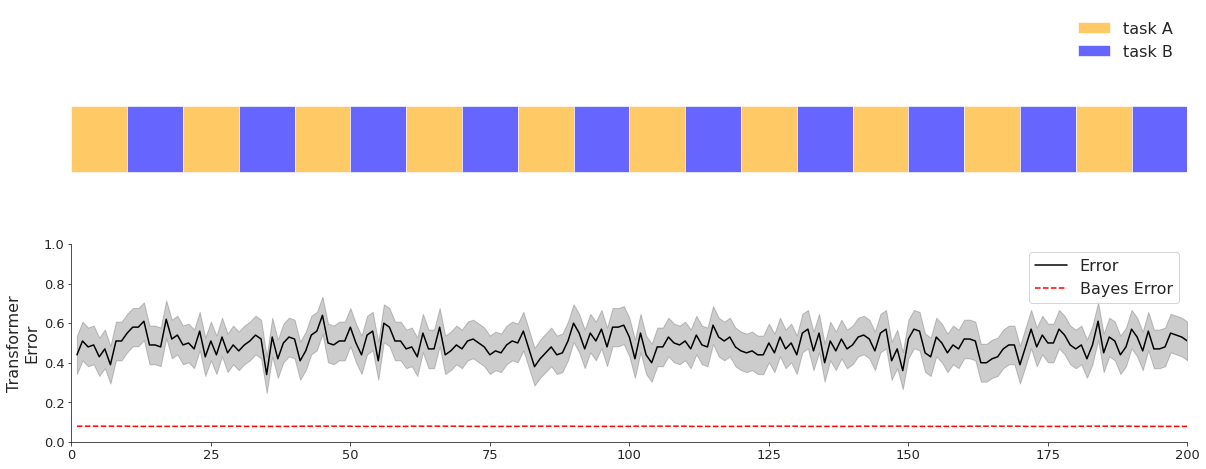

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))
ax = axes[0]
end = 200+1
xlocs = np.arange(0, end, N)
for i, x in enumerate(xlocs):
    if i % 2 == 0:
        ax.add_artist(Rectangle((x, 0), N, 2, fc='orange', alpha=0.6))
    else:
        ax.add_artist(Rectangle((x, 0), N, 2, fc='b', alpha=0.6))
ax.set_ylim([-1, 5])
ax.set_xlim([xlocs[0], xlocs[-1]])
ax.legend(["task A", "task B"], loc=1, frameon=False, fontsize=16)
ax.axis('off')

sns.set_style("white")
sns.set_style("ticks")

ax = axes[1]
ax.plot(np.arange(1, end), mean_error[:end-1], c='k')

# plot bayes error
bayes_error = np.zeros(len(np.arange(1, end)))
for t in range(len(bayes_error)):
    if (t // N) % 2 == 0:
        bayes_error[t] = bayes_error_A
    else:
        bayes_error[t] = bayes_error_B

ax.plot(np.arange(1, end), bayes_error, c='r', ls='--')
x = np.arange(1, end)
y = mean_error[:end-1]
c = ci[:end-1]
plt.fill_between(x, y-c, y+c, alpha=0.2, color='k')
ax.set_ylabel("Transformer" + "\n" + "Error", fontsize=16)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=13)
ax.set_xlim([xlocs[0], xlocs[-1]])
ax.set_ylim([0, 1])
ax.legend(['Error', 'Bayes Error'])
plt.show()


### Comparison with online learners

In [17]:
ogd_error = np.load('results/ogd_error.npy')
ftl_error = np.load('results/ftl_error.npy')
c_ogd = np.load('results/ogd_conf.npy')
c_ftl = np.load('results/ftl_conf.npy')

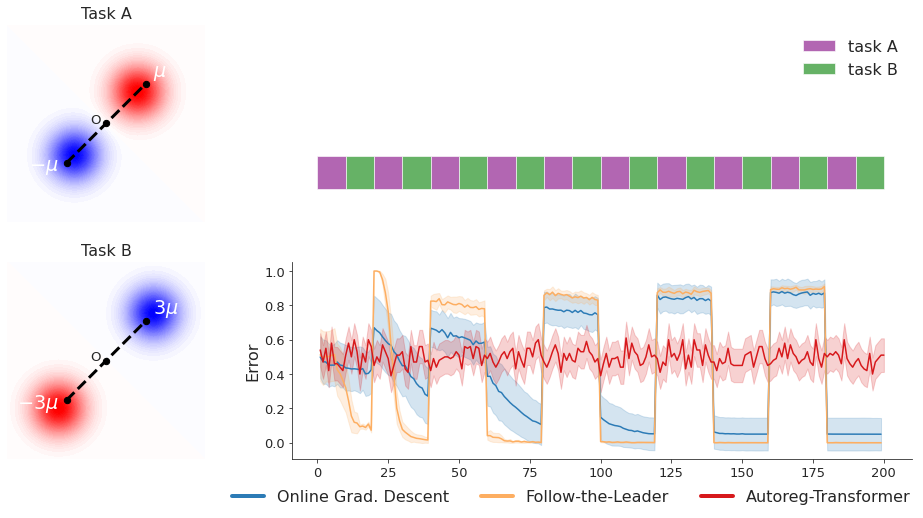

In [18]:
left = [['left1'], 
        ['left2'],]
right = [['right1'],
         ['right2']]
fig, axes = plt.subplot_mosaic([[left, right]], figsize=(20, 8))

ax = axes['left1']

sns.set_palette('pastel')

x, y = np.mgrid[-3:3:.1, -3:3:.1]
rv = multivariate_normal([0.8, 0.8], 0.20*np.eye(2))
data = np.dstack((x, y))
z1 = rv.pdf(data)
rv = multivariate_normal([-0.8, -0.8], 0.20*np.eye(2))
data = np.dstack((x, y))
z2 = rv.pdf(data)
z = z1 - z2
ax.contourf(x, y, z, cmap='bwr', levels=100, alpha=1, extend='both')

ax.plot([-1, 1], [-1, 1], c='k', lw=3, ls="dashed")
ax.scatter([0], [0], c='k', s=40)
ax.scatter([1], [1], c='k', s=40)
ax.scatter([-1], [-1], c='k', s=40)
ax.text(-0.4, 0, "O", size='small')
ax.text(-1.2, -1.2, r"$-\mu$", size='large', ha='right', color='white')
ax.text(1.2, 1.2, r"$\mu$", size='large', ha='left', color='white')
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
ax.set_aspect("equal")
ax.set_title("Task A", fontsize=16)
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
# ax.legend(["Y = 1", "Y = -1"], fontsize=13, frameon=False, loc=2)
ax.set_xticks([])
ax.set_yticks([])

ax = axes['left2']

x, y = np.mgrid[-3:3:.1, -3:3:.1]
rv = multivariate_normal([-1.2, -1.2], 0.20*np.eye(2))
data = np.dstack((x, y))
z1 = rv.pdf(data)
rv = multivariate_normal([1.2, 1.2], 0.20*np.eye(2))
data = np.dstack((x, y))
z2 = rv.pdf(data)
z = z1 - z2
ax.contourf(x, y, z, cmap='bwr', levels=100, alpha=1, extend='both')

ax.plot([-1, 1], [-1, 1], c='k', lw=3, ls="dashed")
ax.scatter([0], [0], c='k', s=40)
ax.scatter([1], [1], c='k', s=40)
ax.scatter([-1], [-1], c='k', s=40)
ax.text(-0.4, 0, "O", size='small')
ax.text(-1.2, -1.2, r"$-3\mu$", size='large', ha='right', color='white')
ax.text(1.2, 1.2, r"$3\mu$", size='large', ha='left', color='white')
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
ax.set_aspect("equal")
ax.set_title("Task B", fontsize=16)
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

ax = axes['right1']
xlocs = np.arange(0, end-1, N)
for i, x in enumerate(xlocs):
    if i % 2 == 0:
        ax.add_artist(Rectangle((x, 0), N, 1, fc='purple', alpha=0.6))
    else:
        ax.add_artist(Rectangle((x, 0), N, 1, fc='g', alpha=0.6))
ax.set_ylim([-1, 5])
ax.legend(["task A", "task B"], loc=1, frameon=False, fontsize=16)
ax.axis('off')

sns.set_style("white")
sns.set_style("ticks")
sns.set_palette('pastel')

ax = axes['right2']
ax.plot(np.arange(1, end-1), ogd_error[:end-1], c='#2c7bb6')
x = np.arange(1, end-1)
y = ogd_error[:end-1]
c = c_ogd[:end-1]
ax.fill_between(x, y-c, y+c, alpha=0.2, color='#2c7bb6')

ax.plot(np.arange(1, end-1), ftl_error[:end-1], c='#fdae61')
x = np.arange(1, end-1)
y = ftl_error[:end-1]
c = c_ftl[:end-1]
ax.fill_between(x, y-c, y+c, alpha=0.2, color='#fdae61')

ax.plot(np.arange(1, end), mean_error[:end-1], c='#d7191c')
x = np.arange(1, end)
y = mean_error[:end-1]
c = ci[:end-1]
ax.fill_between(x, y-c, y+c, alpha=0.2, color='#d7191c')

ax.set_ylabel("Error", fontsize=16)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=13)

legend_elements = [Line2D([0], [0], color='#2c7bb6', lw=4, label='Online Grad. Descent'),
                    Line2D([0], [0], color='#fdae61', lw=4, label='Follow-the-Leader'),
                    Line2D([0], [0], color='#d7191c', lw=4, label='Autoreg-Transformer'),
                ]

ax.legend(handles=legend_elements, loc=8, bbox_to_anchor=(0.2, -0.3, 0.5, 0.5), ncol=3, frameon=False)

axes['right1'].set_xlim(ax.get_xlim())
plt.subplots_adjust(wspace=-0.2)
plt.show()

In [19]:
fig.savefig("figures/transformer-results.pdf", bbox_inches='tight')